# Notebook to Investigate LSTM Performance Variance by Huc Type

# Step 0 - Set up Notebook

In [5]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.datapipe import snow_types as st

ModuleNotFoundError: No module named 'snowML'

In [6]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [7]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [8]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [9]:
# function to extract data from a given epoch 
def summarize_by_step(df, step, agg_lev = 12):
    df_filtered = df[df["Step"] == step].copy()
    df_filtered["Metric_Type"] = df_filtered["Metric"].str.extract(r"(test_mse|test_kge|train_mse|train_kge)")
    df_filtered["HUC_ID"] = df_filtered["Metric"].str.extract(fr"(\d{{{agg_lev}}})")  

    # Take mean across HUC_ID if duplicates exist
    if df_filtered.duplicated(subset=["HUC_ID", "Metric_Type"]).any():
        df_filtered = df_filtered.groupby(["HUC_ID", "Metric_Type"], as_index=False)["Value"].mean()

    df_pivot = df_filtered.pivot(index="HUC_ID", columns="Metric_Type", values="Value")
    df_pivot.columns = ["Test KGE", "Test MSE", "Train KGE", "Train_MSE"]
    df_pivot_sorted = df_pivot.sort_index()
    df_selected = df_pivot_sorted[["Test MSE", "Test KGE"]]
    # print(df_selected)
    return df_selected

In [11]:
# set mlFlow tracking server
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
# define our run_ids by recognizable names 
all_single = "69d929bbdfdd43b4a2f45b823d945eb7" # ~300 different huc12 units, 10 epochs each, dapper-pig-680 

In [12]:
df_all_single = load_ml_metrics(tracking_uri, all_single, save_local=True)

In [7]:
# upload from local 
#df_all_single = pd.read_csv("run_id_data/metrics_from_69d929bbdfdd43b4a2f45b823d945eb7.csv")

In [13]:
df_all_single.head(2)

,Metric,Step,Value
0,train_mse_170103040305,0,0.029135
1,train_mse_170103040305,1,0.008264


In [14]:
df9 = summarize_by_step(df_all_single, 9)

In [17]:
df9.head(2)

,Test MSE,Test KGE
HUC_ID,,
170103020101,0.002134,0.955466
170103020102,0.001441,0.940890


In [24]:
def count_huc8(df):
    # Extract the first 10 digits of each huc_id
    huc8_counts = df.index.astype(str).str[:8].value_counts()
    return huc8_counts

In [26]:
huc_8_count = count_huc8(df9)

In [27]:
huc_8_count

HUC_ID
17010304    52
17030001    52
17110005    46
17020011    43
17020010    41
17030002    29
17020009    29
17110006    15
17010302     8
Name: count, dtype: int64

# Step 2 - Plot histogram of test_kge for each epoch 

In [14]:
def plot_test_kge_histogram(df, output_file = "histogram.png"):
    """
    Plots a histogram of the test_kge values from a pandas DataFrame and saves it as 'histogram.png'.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the column 'test_kge'.
    """
    if 'Test KGE' not in df.columns:
        raise ValueError("DataFrame must contain a 'Test KGE' column")
    
    test_kge_values = df['Test KGE'].dropna()
    median_kge = np.median(test_kge_values)
    
    plt.figure(figsize=(8, 6))
    plt.hist(df['Test KGE'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(median_kge, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_kge:.2f}')
    plt.text(median_kge, plt.ylim()[1] * 0.9, f'Median: {median_kge:.2f}', color='red', ha='right', fontsize=12, fontweight='bold')
    plt.xlabel('Test KGE')
    plt.ylabel('Frequency')
    plt.title('Histogram of Test KGE Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(output_file)
    return plt


In [15]:
def stepwise_hists(metrics, epochs, f_out):

    temp_files = []

    for epoch in range(epochs): 
        metrics_epoch = summarize_by_step(metrics, epoch, agg_lev=12)  
        temp_file = f"hist_epoch_{epoch}.png"
        plot_test_kge_histogram(metrics_epoch, output_file=temp_file)
        temp_files.append((epoch, temp_file))
    
    # Determine grid size
    num_histograms = len(temp_files)
    cols = 3  # Three per row
    rows = (num_histograms + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))  # Adjust figure size
    axes = np.array(axes).reshape(rows, cols)  # Ensure axes is always 2D

    for ax in axes.flat:
        ax.axis("off")  # Hide all axes initially

    for (epoch, temp_file), ax in zip(temp_files, axes.flat):
        img = plt.imread(temp_file)  # Load the image
        ax.imshow(img)
        ax.set_title("Histograme of Test KGE Values", fontsize=14, fontweight="bold")
        ax.axis("off")  # Hide axis labels

    plt.tight_layout()
    plt.show()
    #f_out = f"kge_hist/{run_id}_all_hists.png"
    plt.savefig(f_out, dpi=300)
    plt.close()

    # Cleanup temporary files
    for _, f in temp_files:
        os.remove(f)

    print(f"Saved combined histogram image as {f_out}")

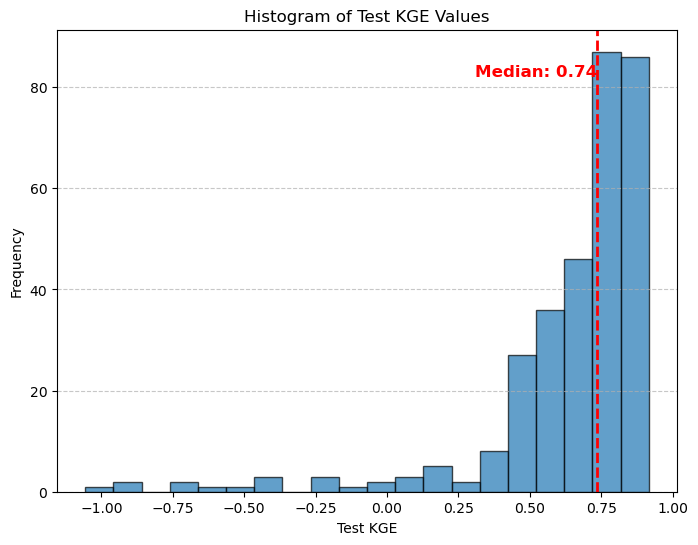

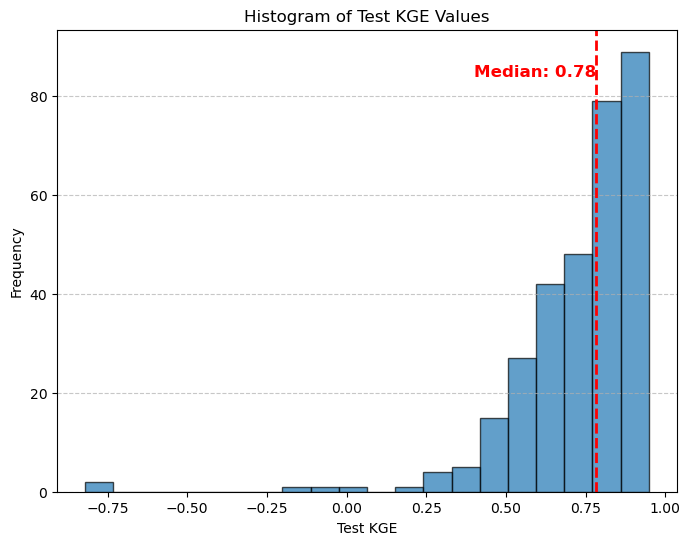

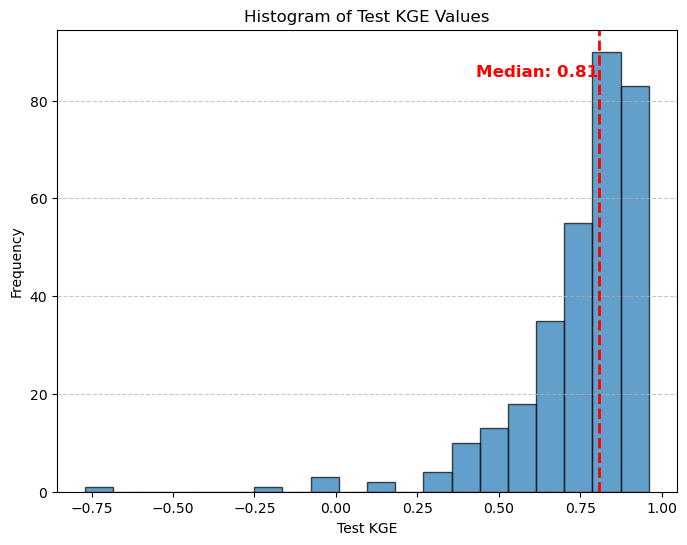

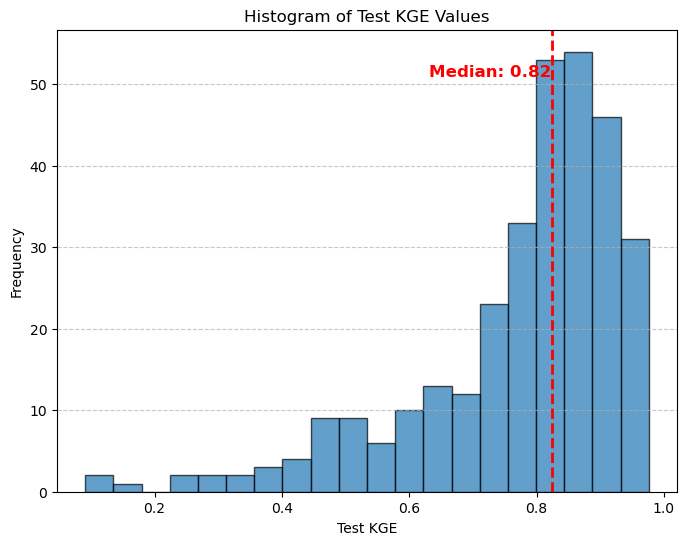

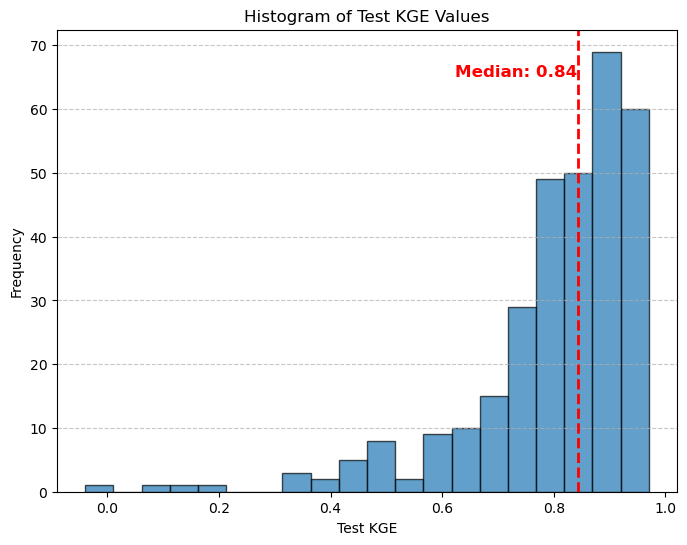

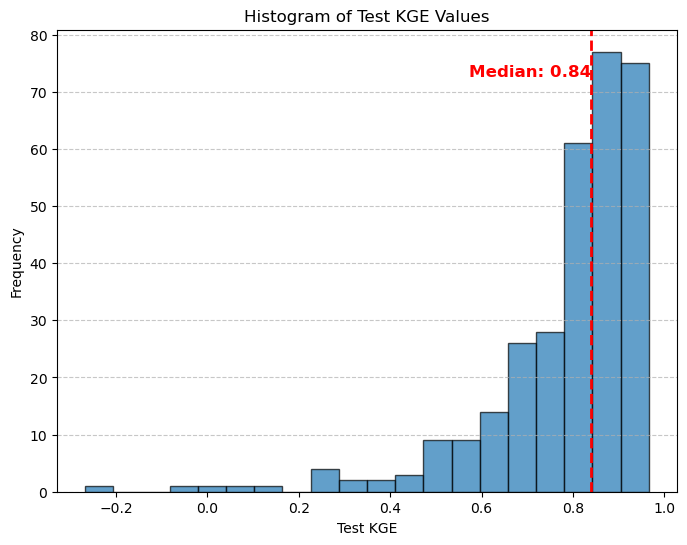

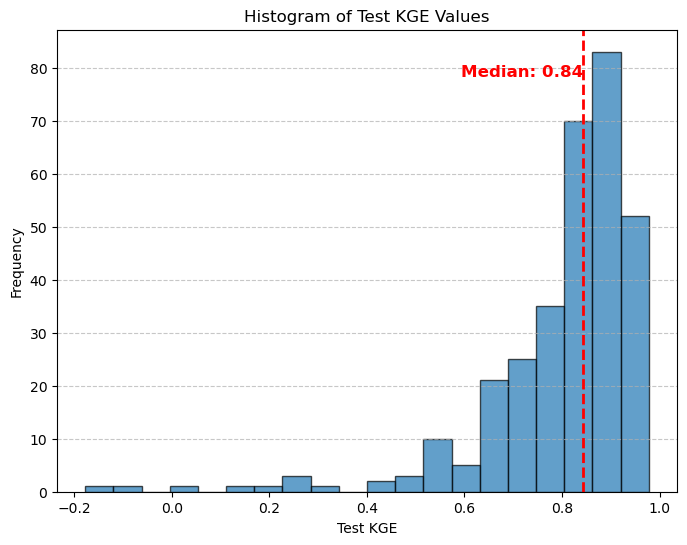

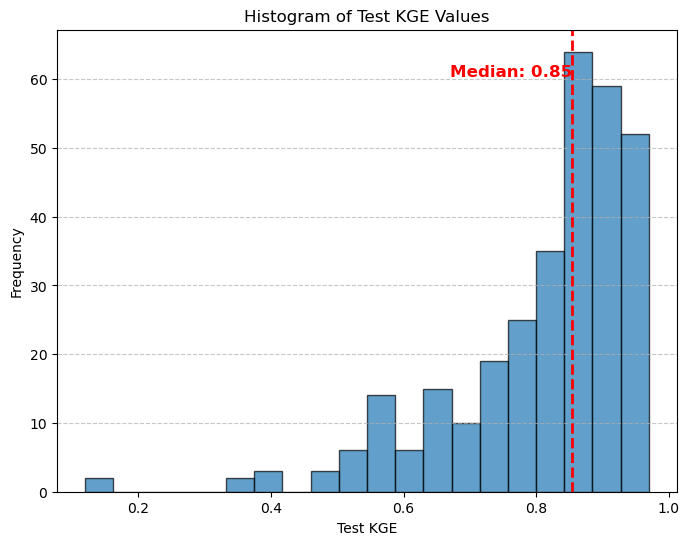

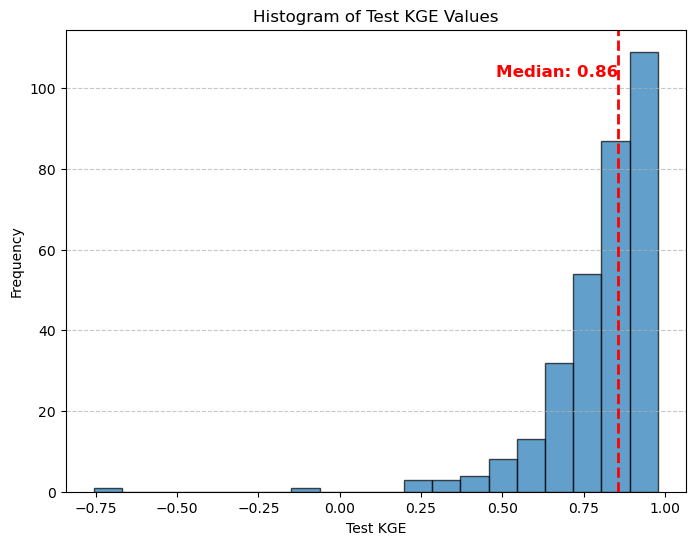

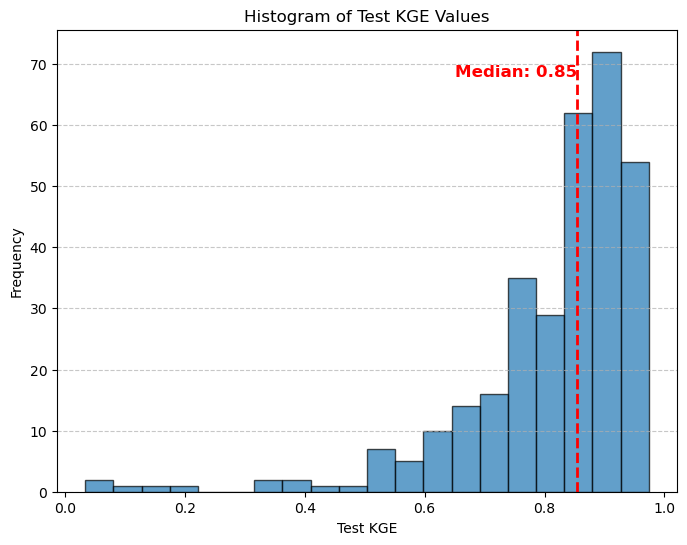

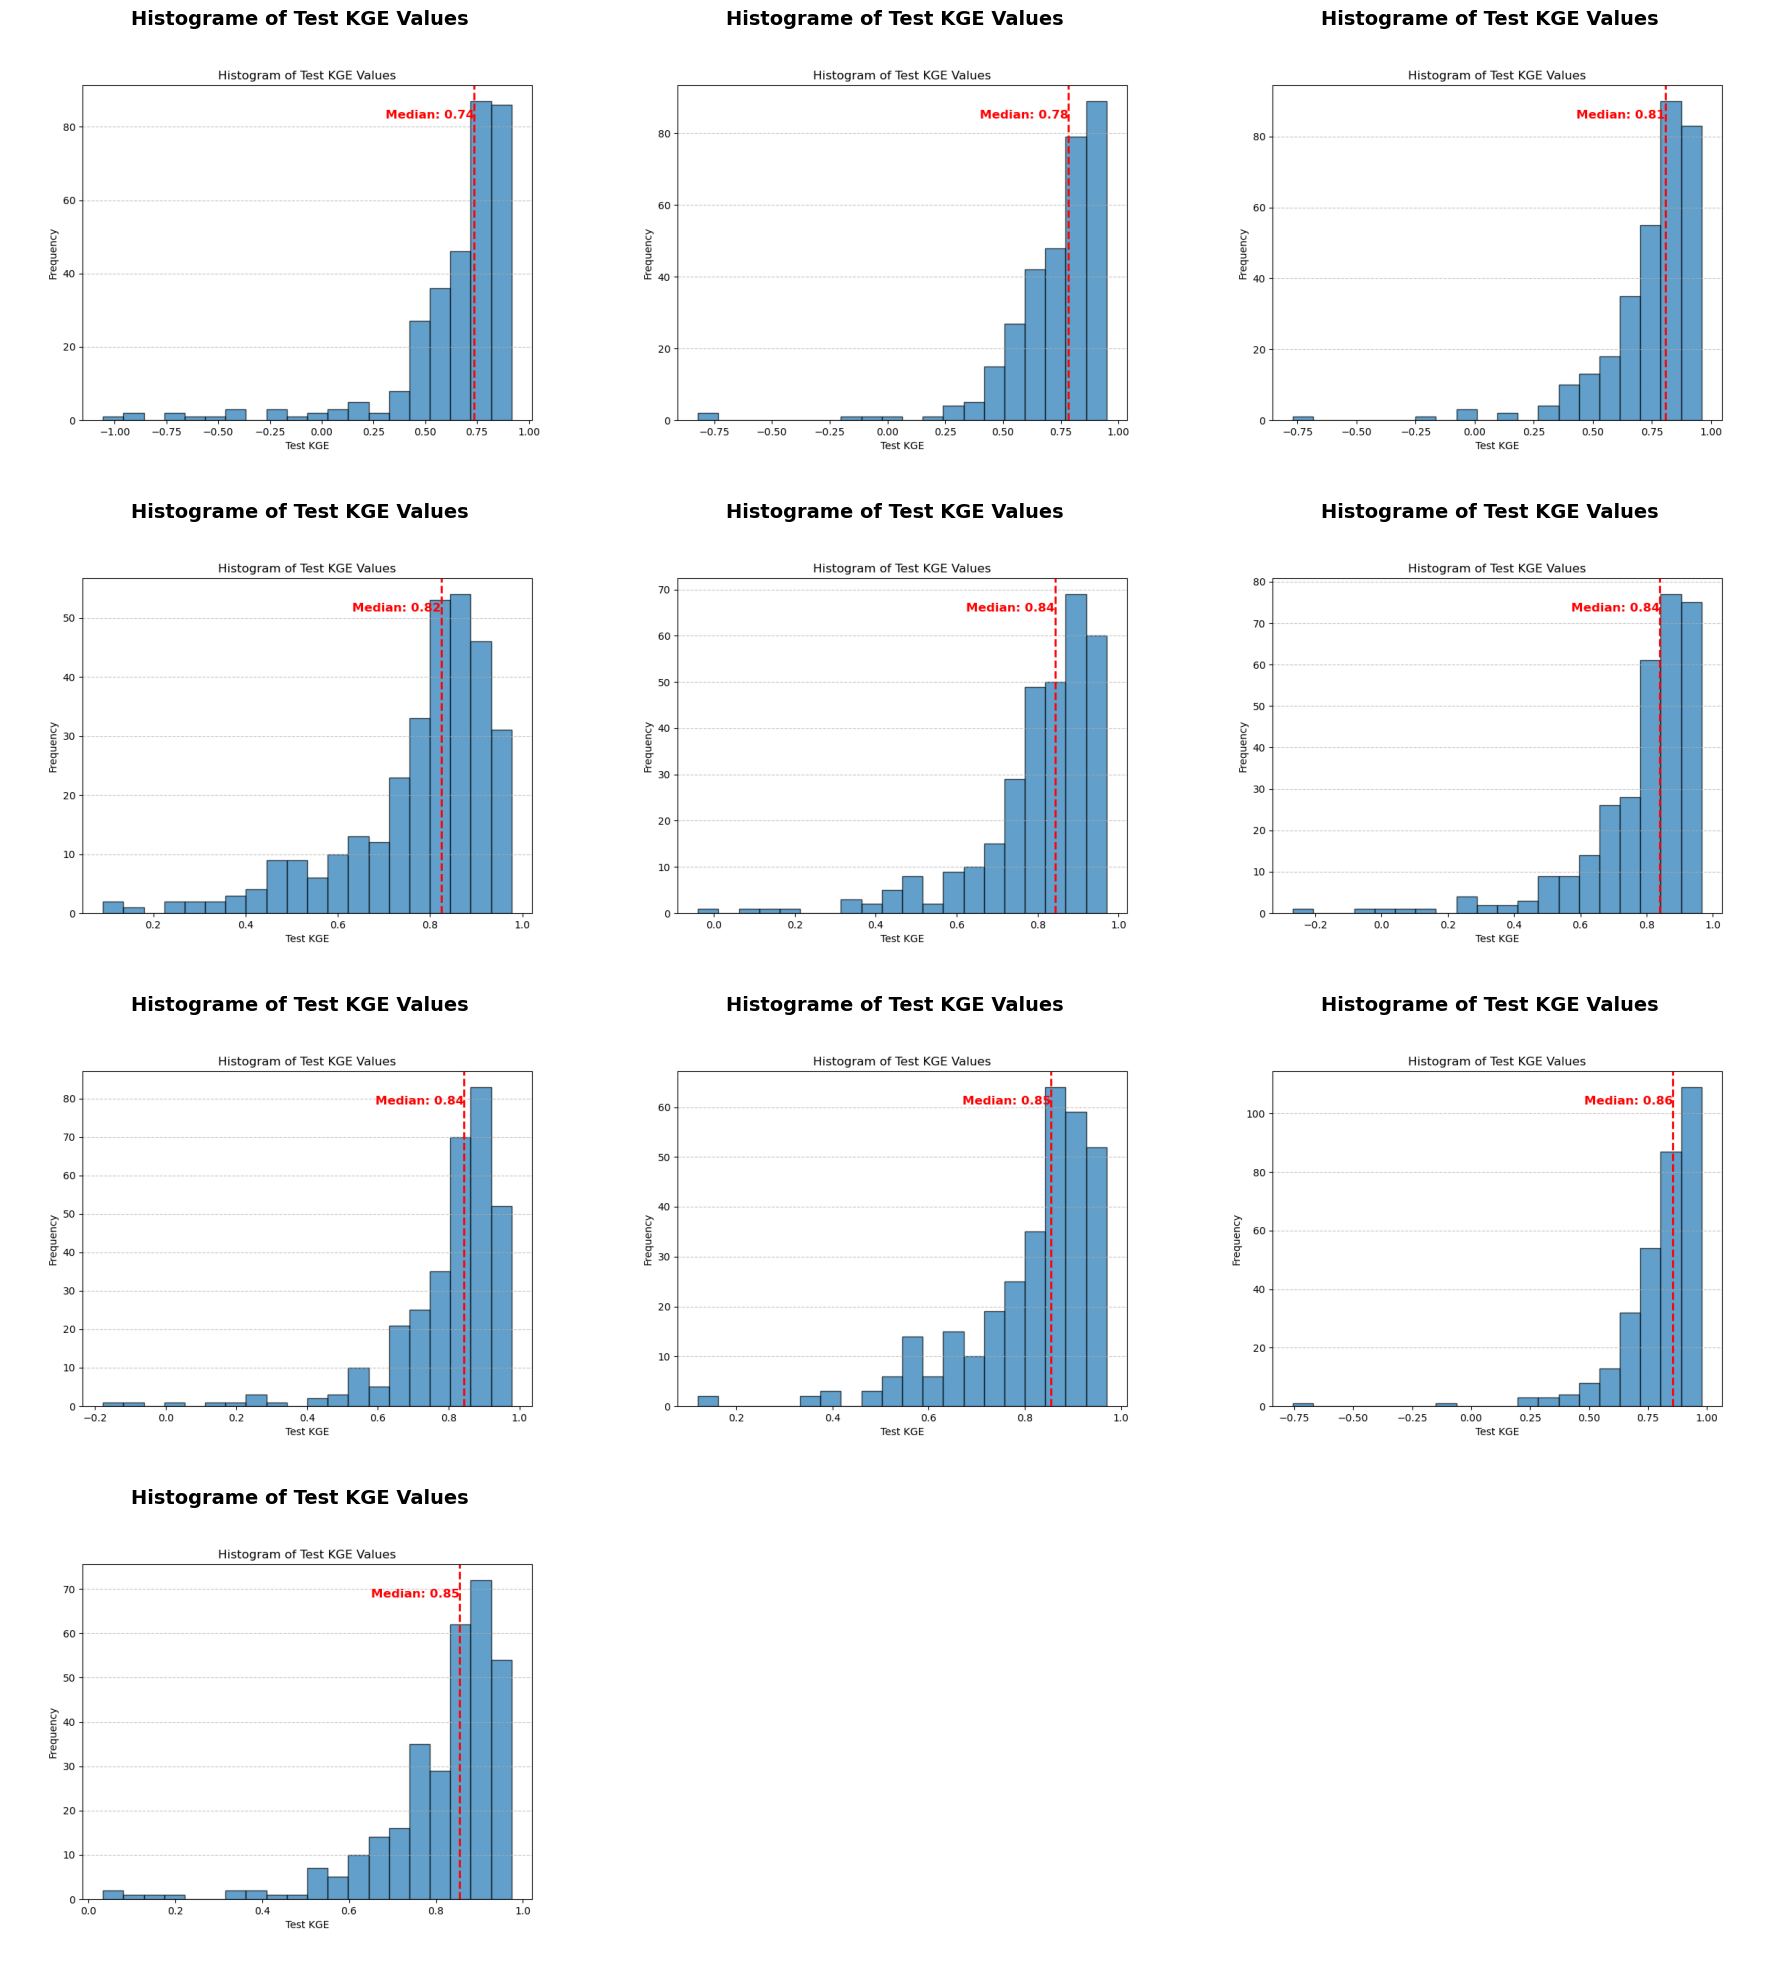

Saved combined histogram image as Stepwise HIstogram All Hucs Singly Trained


In [17]:
stepwise_hists(df_all_single, 10, "Stepwise HIstogram All Hucs Singly Trained")

# Step 3 - Analyze KGE Variability 

In [19]:
# extract the last epoch of data 
df_all_ep10 =  summarize_by_step(df_all_single, 9, agg_lev = 12)
print(df_all_ep10.shape)
df_all_ep10.head()

(315, 2)


,Test MSE,Test KGE
HUC_ID,,
170103020101,0.002134,0.955466
170103020102,0.001441,0.940890
170103020103,0.001903,0.911015
170103020201,0.004779,0.771304
170103020202,0.001719,0.755668


In [20]:
# get the snow class data 
HUC_LIST = [17010302, 17010304,
            17020009, 17020010, 17020011,
            17030001, 17030002, 
            17110005, 17110006, 17110007, 17110008, 17110009]
HUC_LIST_OF_LISTS = [[huc, '12'] for huc in HUC_LIST]
df_dict = {} 
for input_pair in HUC_LIST_OF_LISTS: 
    #print(f"processing huc {input_pair[0]}")
    _, _, df_predom = st.process_all(input_pair[0], input_pair[1])
    df_dict[input_pair[0]] = df_predom


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fce77a252d0>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x7fce615d7150>, 29998.321554352)]']
connector: <aiohttp.connector.TCPConnector object at 0x7fce77004f50>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fce76e04250>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x7fce615d73f0>, 29998.292421667)]']
connector: <aiohttp.connector.TCPConnector object at 0x7fce76e07f90>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fce76ce3950>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x7fce615d72a0>, 29998.306993526)]']
connector: <aiohttp.connector.TCPConnector object at 0x7fce76ce1d50>


In [21]:
# combine the dfs
df_list = []
for huc_id, df in df_dict.items():
    df_list.append(df)
df_extra = pd.concat(df_list)
df_extra = df_extra.set_index("huc_id")
print(df_extra.shape)
df_extra.head(2)

(384, 9)


,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean,Predominant_Snow
huc_id,,,,,,,,,
170103020101,0.0,0.0,0.0,0.0,11.0,89.0,0.0,0.0,Montane Forest
170103020102,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest


In [22]:
# Merge the additional data with df_all_ep10 based on the index (huc_id)
df_merged = df_all_ep10.merge(df_extra, left_index=True, right_index=True, how="left")

# select columns to display
col_to_kp = ["Test MSE", "Test KGE", "Ephemeral", "Predominant_Snow"]
df_merged = df_merged[col_to_kp]

# Display the updated worst10
df_merged.head(2)

,Test MSE,Test KGE,Ephemeral,Predominant_Snow
HUC_ID,,,,
170103020101,0.002134,0.955466,0.0,Montane Forest
170103020102,0.001441,0.940890,0.0,Montane Forest


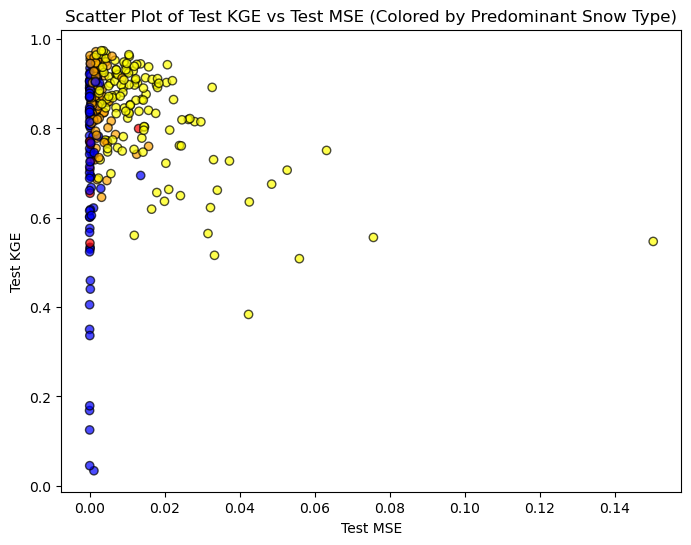

In [23]:
# Define color mapping
color_map = {
    "Ephemeral": "blue",
    "Maritime": "yellow",
    "Montane Forest": "orange"
}

# Assign colors based on the Predominant_Snow column, defaulting to red if not in the map
df_merged["color"] = df_merged["Predominant_Snow"].map(color_map).fillna("red")

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_merged["Test MSE"], df_merged["Test KGE"], c=df_merged["color"], alpha=0.7, edgecolors="k")

# Add labels and title
plt.xlabel("Test MSE")
plt.ylabel("Test KGE")
plt.title("Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)")

# Show plot
plt.show()

In [24]:
df_noE = df_merged[df_merged["Predominant_Snow"] != "Ephemeral"]
print(df_noE.shape)
df_noE.head(2)

(228, 5)


,Test MSE,Test KGE,Ephemeral,Predominant_Snow,color
HUC_ID,,,,,
170103020101,0.002134,0.955466,0.0,Montane Forest,orange
170103020102,0.001441,0.940890,0.0,Montane Forest,orange


In [25]:
# Calculate median and mean Test KGE by snow type
summary_stats = df_merged.groupby("Predominant_Snow")["Test KGE"].agg(["median", "mean"])
print(summary_stats)

                    median      mean
Predominant_Snow                    
Boreal Forest     0.799717  0.799717
Ephemeral         0.806826  0.732389
Maritime          0.864032  0.830242
Montane Forest    0.892441  0.872785
Prairie           0.727254  0.701702


In [26]:
# Calculate median and mean Test MSE by snow type
summary_stats = df_merged.groupby("Predominant_Snow")["Test MSE"].agg(["median", "mean"])
print(summary_stats)

                    median      mean
Predominant_Snow                    
Boreal Forest     0.013085  0.013085
Ephemeral         0.000130  0.000557
Maritime          0.010866  0.015913
Montane Forest    0.001679  0.002381
Prairie           0.000139  0.000252


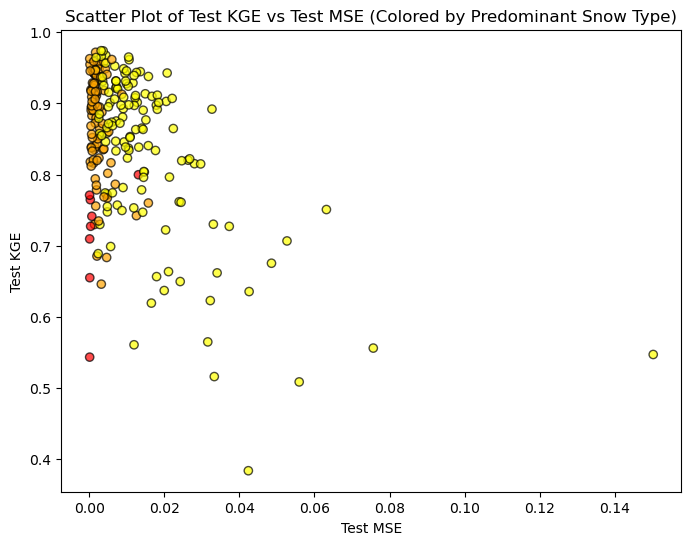

In [27]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_noE["Test MSE"], df_noE["Test KGE"], c=df_noE["color"], alpha=0.7, edgecolors="k")

# Add labels and title
plt.xlabel("Test MSE")
plt.ylabel("Test KGE")
plt.title("Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)")

# Show plot
plt.show()

In [102]:
def determine_mixed(row):
    predominant_snow = row['Predominant_Snow']
    percentage = row[predominant_snow]
    return 'Yes' if percentage < 70 else 'No'

df_mixed = df_extra.copy()
df_mixed['Mixed'] = df_mixed.apply(determine_mixed, axis=1)
df_mixed.head(10)

,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean,Predominant_Snow,Mixed
huc_id,,,,,,,,,,
170103020101,0.0,0.0,0.0,0.0,11.0,89.0,0.0,0.0,Montane Forest,No
170103020102,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest,No
170103020103,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest,No
170103020201,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest,No
170103020202,0.0,0.0,0.0,12.0,0.0,88.0,0.0,0.0,Montane Forest,No
170103020301,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest,No
170103020302,0.0,0.0,0.0,17.0,0.0,83.0,0.0,0.0,Montane Forest,No
170103020303,0.0,0.0,0.0,22.0,0.0,78.0,0.0,0.0,Montane Forest,No
170103040101,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest,No


In [103]:
# Merge the additional data with df_all_ep10 based on the index (huc_id)
df_merged2 = df_all_ep10.merge(df_mixed, left_index=True, right_index=True, how="left")

# select columns to display
col_to_kp = ["Test MSE", "Test KGE", "Ephemeral", "Predominant_Snow", "Mixed"]
df_merged2 = df_merged2[col_to_kp]

# Display the updated worst10
df_merged2.head(2)

,Test MSE,Test KGE,Ephemeral,Predominant_Snow,Mixed
HUC_ID,,,,,
170103020101,0.002134,0.955466,0.0,Montane Forest,No
170103020102,0.001441,0.940890,0.0,Montane Forest,No


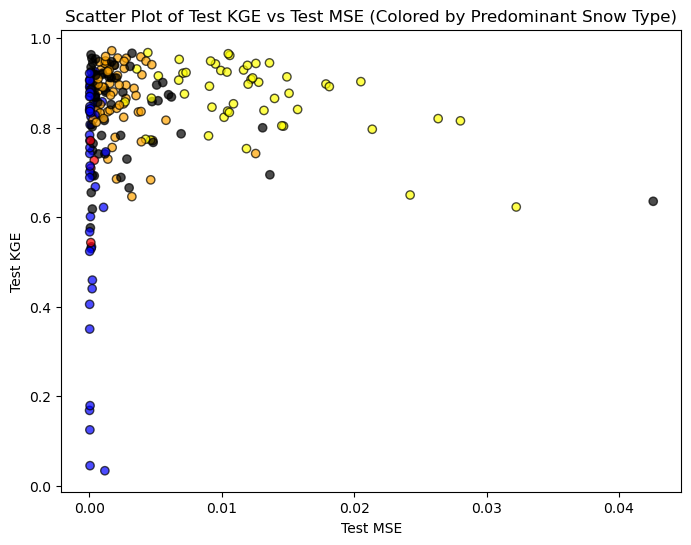

In [104]:
# Define color mapping
color_map = {
    "Ephemeral": "blue",
    "Maritime": "yellow",
    "Montane Forest": "orange"
}

# Assign colors based on the Predominant_Snow column, defaulting to red if not in the map
df_merged2["color"] = df_merged2["Predominant_Snow"].map(color_map).fillna("red")

# Change color to black where Mixed is "Yes"
df_merged2.loc[df_merged2['Mixed'] == 'Yes', 'color'] = 'black'

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_merged2["Test MSE"], df_merged2["Test KGE"], c=df_merged2["color"], alpha=0.7, edgecolors="k")

# Add labels and title
plt.xlabel("Test MSE")
plt.ylabel("Test KGE")
plt.title("Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)")

# Show plot
plt.show()

In [105]:
df_noE2 = df_merged2[df_merged2["Predominant_Snow"] != "Ephemeral"]
print(df_noE2.shape)
df_noE2.head(2)

(146, 6)


,Test MSE,Test KGE,Ephemeral,Predominant_Snow,Mixed,color
HUC_ID,,,,,,
170103020101,0.002134,0.955466,0.0,Montane Forest,No,orange
170103020102,0.001441,0.940890,0.0,Montane Forest,No,orange


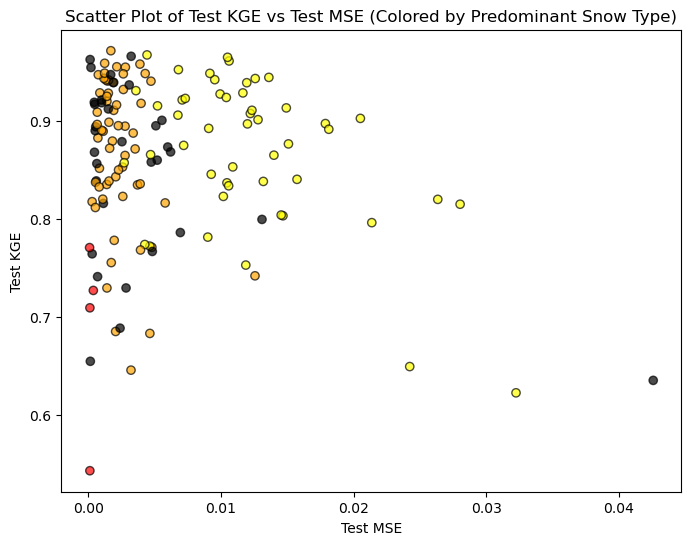

In [106]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_noE["Test MSE"], df_noE2["Test KGE"], c=df_noE2["color"], alpha=0.7, edgecolors="k")

# Add labels and title
plt.xlabel("Test MSE")
plt.ylabel("Test KGE")
plt.title("Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)")

# Show plot
plt.show()

In [107]:
# Create the 'Final Snow Type' column
df_merged2["Final Snow Type"] = df_merged2.apply(
    lambda row: "Mixed" if row["Mixed"] == "Yes" else row["Predominant_Snow"], axis=1
)

# Calculate mean and median of Test KGE by Final Snow Type
mean_test_kge = df_merged2.groupby("Final Snow Type")["Test KGE"].mean()
median_test_kge = df_merged2.groupby("Final Snow Type")["Test KGE"].median()

# Print the results
print("Mean Test KGE by Final Snow Type:")
print(mean_test_kge)
print("\nMedian Test KGE by Final Snow Type:")
print(median_test_kge)

Mean Test KGE by Final Snow Type:
Final Snow Type
Ephemeral         0.682332
Maritime          0.870711
Mixed             0.838832
Montane Forest    0.870350
Prairie           0.687762
Name: Test KGE, dtype: float64

Median Test KGE by Final Snow Type:
Final Snow Type
Ephemeral         0.783577
Maritime          0.892614
Mixed             0.870629
Montane Forest    0.888742
Prairie           0.718386
Name: Test KGE, dtype: float64


In [108]:
# Calculate mean and median of Test MSE by Final Snow Type
mean_test_mse = df_merged2.groupby("Final Snow Type")["Test MSE"].mean()
median_test_mse = df_merged2.groupby("Final Snow Type")["Test MSE"].median()

# Print the results
print("Mean Test MSE by Final Snow Type:")
print(mean_test_mse)
print("\nMedian Test MSE by Final Snow Type:")
print(median_test_mse)

Mean Test MSE by Final Snow Type:
Final Snow Type
Ephemeral         0.000193
Maritime          0.012158
Mixed             0.002600
Montane Forest    0.002302
Prairie           0.000165
Name: Test MSE, dtype: float64

Median Test MSE by Final Snow Type:
Final Snow Type
Ephemeral         0.000051
Maritime          0.010881
Mixed             0.000801
Montane Forest    0.001853
Prairie           0.000106
Name: Test MSE, dtype: float64
